In [ ]:
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt      
import matplotlib.image as mpimg                  
%matplotlib inline                              

#!pip install torch
#!pip install torchvision
#!pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary
import torch.optim as optim
import os

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image, ImageOps
ImageFile.LOAD_TRUNCATED_IMAGES = True

from torch.utils.data.sampler import SubsetRandomSampler
from glob import glob
import numpy as np
import random
from random import shuffle

from collections import Counter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix



In [ ]:
#!unzip Magnetic_tile_defect_datasets.zip

In [ ]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is not available. Training on CPU ...


In [ ]:
# define classes which are folders in main data directory with these names
classes =['Blowhole', 'Crack', 'Break', 'Fray', 'Uneven', 'Free']

#### Plot sample images and their masks

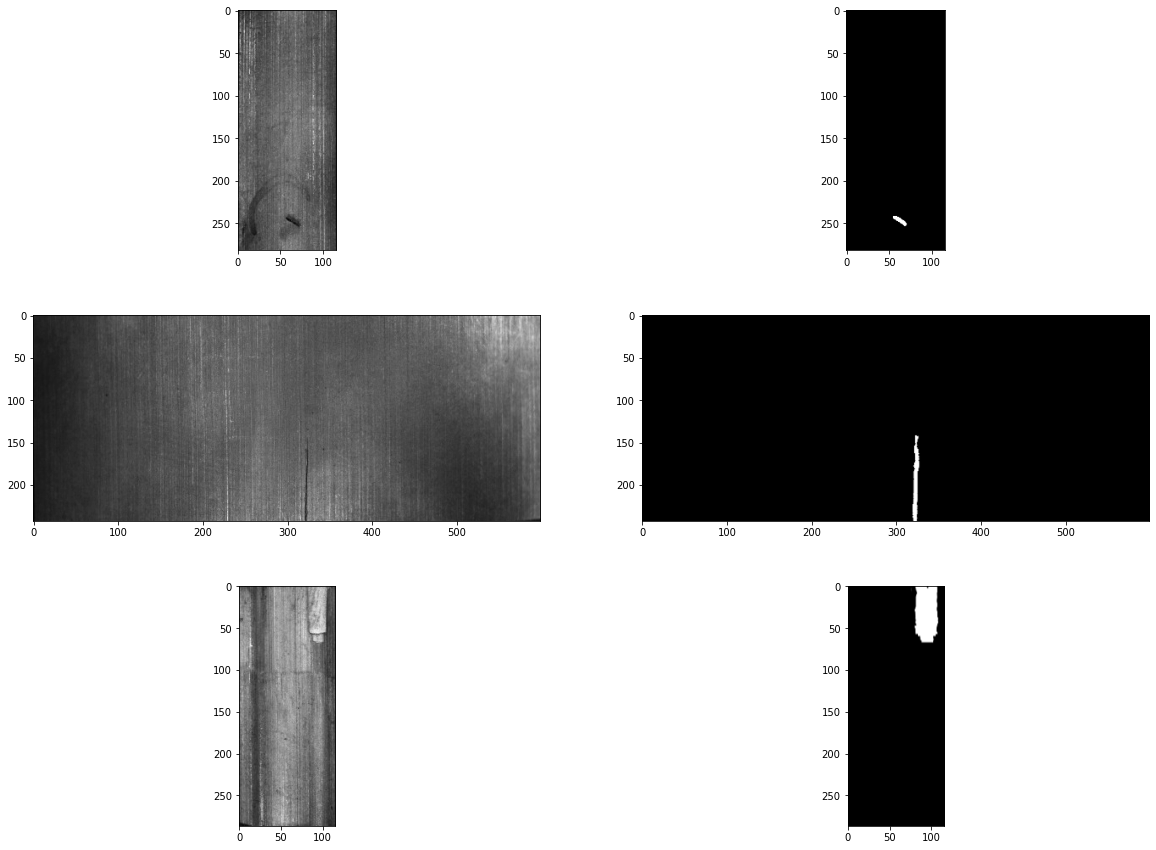

In [ ]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944','data/MT_Crack/Imgs/exp1_num_86828','/home/jovyan/work/data/MT_Break/Imgs/exp1_num_62553']

fig =  plt.figure(figsize=(20, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    #plt.imshow(Image.open(im_path+'.jpg').convert("RGB"))
    plt.imshow(Image.open(im_path+'.jpg'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    #plt.imshow(ImageOps.grayscale(Image.open(im_path+'.png')))
    #plt.imshow(Image.open(im_path+'.png').convert("RGB"))
    plt.imshow(Image.open(im_path+'.png'), cmap='gray')


#### Check the number of channels

In [ ]:
image = Image.open('data/MT_Blowhole/Imgs/exp1_num_4944.jpg')
mask = Image.open('data/MT_Blowhole/Imgs/exp1_num_4944.png')#.convert("RGB")
print('image: ', image.size, ' ', 'mask: ', mask.size)

image:  (116, 282)   mask:  (116, 282)


In [ ]:
# check the range of colors in image and mask
[[np.min(image),np.max(image)], [np.min(mask),np.max(mask)]]

[[10, 126], [0, 255]]

## Dataset

In [ ]:
from my_classes.transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from my_classes.dataset import SurfaceDefectDetectionDataset, partitioning
from my_classes.loss import FocalLoss
from my_classes.unet import UNet

In [ ]:
split_ratio = [0.60, 0.20, 0.20]
partition = partitioning(split_ratio)


Blowhole _  train:  69   val:  23   test:  23   total:  115
Crack _  train:  34   val:  11   test:  12   total:  57
Break _  train:  51   val:  17   test:  17   total:  85
Fray _  train:  19   val:  6   test:  7   total:  32
Uneven _  train:  61   val:  21   test:  21   total:  103
Free _  train:  571   val:  190   test:  191   total:  952


In [ ]:
['train: ', len(partition['train']), ' ','val: ', len(partition['val']), ' ','test: ', len(partition['test'])]

['train: ', 805, ' ', 'val: ', 268, ' ', 'test: ', 271]

In [ ]:
partition['train'][0]

'data/MT_Blowhole/Imgs/exp4_num_328029.jpg'

#### Test out some transforms


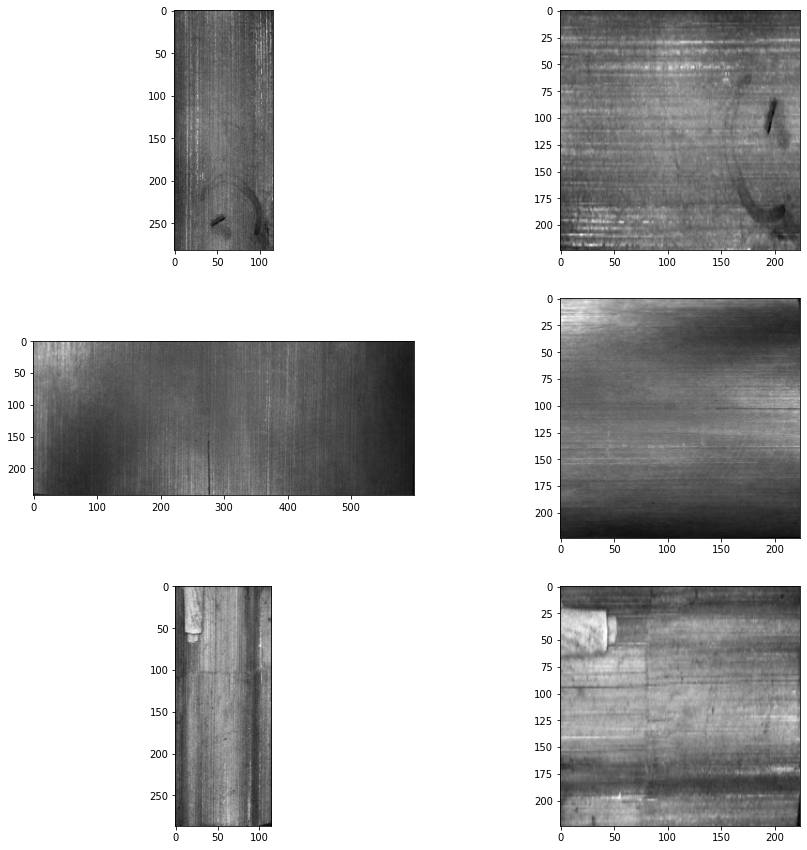

In [ ]:
images_path=['data/MT_Blowhole/Imgs/exp1_num_4944',
            'data/MT_Crack/Imgs/exp1_num_86828',
            '/home/jovyan/work/data/MT_Break/Imgs/exp1_num_62553']

fig =  plt.figure(figsize=(15, 15))
n=len(images_path)
for i, im_path in enumerate(images_path):
    #image = Image.open(images_path[i]+'.jpg').convert("RGB")
    image = Image.open(images_path[i]+'.jpg')
    #mask = Image.open(images_path[i]+'.png').convert("RGB")
    mask = Image.open(images_path[i]+'.png')
    t1 = HorizontalFlip()
    t2 = Resize((224,224))
    t3 = Rotate(90)
    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(t1(image), cmap='gray')  # Added by Ray
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(t3(t2(image)), cmap='gray')


### Construct the transformed dataset

In [ ]:
# Construct the dataset
surface_defect_dataset ={}
for p in ['train', 'val', 'test']:
    surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p])

#### some stats about the dataset

In [ ]:
partition['train'][0:3]

['data/MT_Blowhole/Imgs/exp4_num_328029.jpg',
 'data/MT_Blowhole/Imgs/exp2_num_3696.jpg',
 'data/MT_Blowhole/Imgs/exp2_num_36302.jpg']

In [ ]:
surface_defect_dataset['train']

In [ ]:
surface_defect_dataset.values()

dict_values([<my_classes.dataset.SurfaceDefectDetectionDataset object at 0x7f061533ec18>, <my_classes.dataset.SurfaceDefectDetectionDataset object at 0x7f061533ec88>, <my_classes.dataset.SurfaceDefectDetectionDataset object at 0x7f061533eef0>])

In [ ]:
surface_defect_dataset.keys()

dict_keys(['train', 'val', 'test'])

In [ ]:
print('Length of dataset: ', len(surface_defect_dataset))
print('Length of train dataset: ', len(surface_defect_dataset['train']))
print('Length of validation dataset: ', len(surface_defect_dataset['val']))
print('Length of test dataset: ', len(surface_defect_dataset['test']))
surface_defect_dataset['test']

Length of dataset:  3
Length of train dataset:  805
Length of validation dataset:  268
Length of test dataset:  271


In [ ]:
SurfaceDefectDetectionDataset

my_classes.dataset.SurfaceDefectDetectionDataset

### Batch and load data

In [ ]:
# CUDA for PyTorch
device = torch.device("cuda" if train_on_gpu else "cpu")
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 16,  #### Please change this
          'shuffle': True,
          'num_workers': 0}
params_val = params.copy()
params_val['shuffle'] = False

# Generators (data loaders)
loaders={}
loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], **params)
loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], **params_val)
loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], **params_val)

### Obtain model architecture

In [ ]:
# instantiate the unet

model = UNet(1,1,32,0.2).to(device)


In [ ]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.to(device)

In [ ]:
summary(model, (1, 224, 224), batch_size=8)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 32, 224, 224]             288
       BatchNorm2d-2          [8, 32, 224, 224]              64
              ReLU-3          [8, 32, 224, 224]               0
            Conv2d-4          [8, 32, 224, 224]           9,216
       BatchNorm2d-5          [8, 32, 224, 224]              64
              ReLU-6          [8, 32, 224, 224]               0
         MaxPool2d-7          [8, 32, 112, 112]               0
           Dropout-8          [8, 32, 112, 112]               0
            Conv2d-9          [8, 64, 112, 112]          18,432
      BatchNorm2d-10          [8, 64, 112, 112]             128
             ReLU-11          [8, 64, 112, 112]               0
           Conv2d-12          [8, 64, 112, 112]          36,864
      BatchNorm2d-13          [8, 64, 112, 112]             128
             ReLU-14          [8, 64, 1

### Specify the loss function and optimizer

In [ ]:
# train criterion
n_epochs = 10
optimizer_type = 'SGD'

In [ ]:
from my_classes.loss import FocalLoss
import torch.optim as optim

# Focal loss function
criterion = FocalLoss()

# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
else:
    optimizer =optim.Adam(model.parameters())

### Train and validate the model

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    loss_epoch =[]
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if train_on_gpu:
                data, target = data.to(device), target.to(device)
             
            # clear the gradients of all optimized variable
            optimizer.zero_grad() 
            # forward pass
            output = model(data) 
            # calculate the batch loss
            loss = criterion (output, target) 
            # backpropagation
            loss.backward() 
            # Update weigths
            optimizer.step() 
            # update training loss
            train_loss +=  ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                      
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['val']):
            # move to GPU
            if train_on_gpu:
                data, target = data.to(device), target.to(device)
            ## update the average validation loss
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = criterion (output, target)
            # update validation loss
            valid_loss +=  ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

        loss_epoch.append((epoch, train_loss.item(), valid_loss.item()))

    #save the loss_epoch history
    df=pd.DataFrame.from_records(loss_epoch, columns=['epoch','Train_loss', 'Validation_loss'])
    df.to_csv('loss.csv', index=False)       
    # return trained model
    return model


In [ ]:
# train the model
model = train(n_epochs,loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))

KernelInterrupted: Execution interrupted by the Jupyter kernel.